# Web Scraping Indeed.com for Key Web Developer Job Skills

## The problem is - What are the "right" skills?

Which web development skills should an aspiring web developer learn to be hired in Palm Beach County, Florida?

## The client:

Palm Beach Code School (PBCS) in Palm Beach Gardens, FL. - palmbeachcodeschool.com .

## The data set:

The data set starts with a list of the target skills that are included in a particular want ad scraped from Indeed.com. Then each of those lists is combined into a totals lists of the number of ads containing each skill.

## Other potential data sets:

We could do a trend analysis by comparing results over several months or compare Palm Beach County's results with other Forida or US locations.

The steps as follows:
* Decide what specific job(s) to be searched - web developer or programmer to start.
* Make a list of all the skills - see the second function below.
* Determine the geographical limits of the search - within 25 miles of West Palm Beach.

To run the scraper, load the following libraries and then define the two main functions: html_cleaner and web_skills_info (both below).

In [2]:
from bs4 import BeautifulSoup as soup # For HTML parsing
from urllib.request import urlopen as uReq # Website connection
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [3]:
def html_cleaner(website):
    '''
    This function cleans the raw html so it's parsible.
    Inputs: a URL to investigate
    Outputs: list of cleaned text
    '''
    try:
        site = uReq(website).read() # Connect to the job posting
    except: 
        return   # In case the website is not found or connection problem
    
    soup_obj = soup(site, "html.parser") # Get the html from the site
    
    if len(soup_obj) == 0: # In parser lxml didn't work, try another one
        soup_obj = soup(site, 'html5lib')
        
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
        
    text = soup_obj.get_text() # Get the text
    
    lines = (line.strip() for line in text.splitlines()) # break into lines
    
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) 
    
    text = ''.join(chunk for chunk in chunks if chunk).encode('utf-8') #remove blank lines
    
    # Now clean out all of the unicode
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore')
    except:                                                            
        return                                                         
    
    text = re.sub("[^a-zA-Z+]"," ", str(text))  # Now get rid of any terms that aren't words 
    
    text = text.lower().split()  # Go to lower case and split them apart
    
    #stop_words = set(stopwords.words("english")) # Filter out any stop words
    man_stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 
            'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 
            'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 
            'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 
            'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 
            'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 
            'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 
            'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 
            'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 
            'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 
            'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 
            'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}
    text = [w for w in text if not w in man_stopwords]
    
    return list(set(text))
    

In [6]:
def web_skills_info(url, city):
    '''
    This function will take a url for web development job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical web skills. The final percentage for each skill
    is then displayed at the end of the collation. 
    
    Input: Indeed first page url for web development search
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a web developer. 
    '''
    current_page = url
    base_url = 'http://www.indeed.com'
    try:
        html = uReq(url).read() # Open up the front page of our search first
    except:
        'Url error - Exiting . . .'
        return
    page_obj = soup(html, "html.parser") # Get the html from the site
    
    num_jobs_area = page_obj.find(id = 'searchCount').string.encode('utf-8') # The total number of jobs found
    job_numbers = re.findall('\d+', str(num_jobs_area)) # Extract the total jobs found from the search result
    total_num_jobs = int(job_numbers[-1])
    print('There were', total_num_jobs, 'web jobs found within a 25 mi radius of ' + city + '.')
    num_pages = int(total_num_jobs/10)
    job_descriptions = [] # Store job descriptions in this list
    
    for i in range(1,num_pages+1): # Loop through search result pages (starting with the current one)
        print('Getting page ' + str(i))
        if i != 1:
            #Get next job page
            start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
            current_page = ''.join([url, '&start=', start_num]) #Set the next page of 10 jobs
            html_page = uReq(current_page).read() # Get the page
            page_obj = soup(html_page, "html.parser")
        job_link_area = page_obj.find(id = 'resultsCol') # Locate all of the links
        all_links = [link.get('href') for link in job_link_area.find_all('a')]
        all_links = [x for x in all_links if type(x) == type('')] # remove non-srings
        job_links = [x for x in all_links if 'clk' in x] # Just job related links
        
        for j in range(0,len(job_links)):
            final_description = html_cleaner(base_url + job_links[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) #Slow down server hits
        
    print('Done with collecting the job postings!')    
    print('There were', len(job_descriptions), 'jobs successfully found.')
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    #key term dicts
    prog_lang_dict = Counter({'Javas':doc_frequency['java'], 'Python':doc_frequency['python'],
                    'Javascrip':doc_frequency['javascript'], 'C++':doc_frequency['c++'],
                   'Ruby':doc_frequency['ruby'], 'PHP':doc_frequency['php'],
                  'CSS':doc_frequency['css'], 'HTML':doc_frequency['html'],
                  'JQuery':doc_frequency['jquery'], 'Angular': doc_frequency['angular']})
    os_dict = Counter({'Linux':doc_frequency['linux'],  'Android':doc_frequency['android'],
                      'iOS':doc_frequency['ios'], 'Windows':doc_frequency['windows'],
                      'Cloud':doc_frequency['cloud'], 'Mobile':doc_frequency['mobile'],
                      'Fullstack':doc_frequency['fullstack']})
    framework_dict = Counter({'BootStrap':doc_frequency['bootstrap'], 'Node':doc_frequency['node'],
                      'Wordpress':doc_frequency['wordpress'], 'Django':doc_frequency['django']})
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                 'Excel':doc_frequency['excel'], 'MySql':doc_frequency['mysql'],
                 'MongoDB':doc_frequency['mongodb']})
    overall_total_skills = prog_lang_dict + os_dict + framework_dict + database_dict # Combine 
    
    final_frame = pd.DataFrame.from_dict(overall_total_skills, orient='index').reset_index()
    final_frame = final_frame.rename(columns={'index':'Term', 0:'NumPostings'})
    final_frame.sort_values('NumPostings', ascending = False, inplace = True)
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Percentages
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                              title = 'Percentage of Web Developer Job Ads with a Key Skill')
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
    
    return fig, final_frame

The search within 25 miles of West Palm Beach:

There were 137 web jobs found within a 25 mi radius of West Palm Beach.
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Done with collecting the job postings!
There were 120 jobs successfully found.


(<matplotlib.figure.Figure at 0x9e8ca850b8>,           Term  NumPostings
 21         SQL    40.000000
 2         Java    39.166667
 7         HTML    30.000000
 0   Javascript    25.833333
 6          CSS    24.166667
 8       JQuery    21.666667
 14       Cloud    20.000000
 15      Mobile    17.500000
 13     Windows    15.833333
 24       MySql    15.833333
 10       Linux    10.833333
 5          PHP    10.833333
 23       Excel     9.166667
 9      Angular     7.500000
 11     Android     5.833333
 1       Python     5.833333
 18   Wordpress     5.000000
 19        Node     5.000000
 3          C++     4.166667
 12         iOS     4.166667
 17   BootStrap     3.333333
 4         Ruby     1.666667
 16   Fullstack     1.666667
 20      Django     1.666667
 22       NoSQL     1.666667)

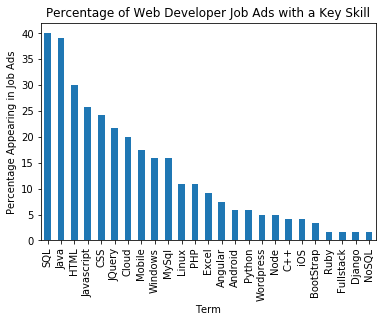

In [7]:
web_site = 'https://www.indeed.com/jobs?q=web+%28developer+or+programmer%29&l=West+Palm+Beach%2C+FL&radius=25'
web_skills_info(web_site, 'West Palm Beach')

## Summary:

No surprise that HTML, CSS, and Javascript are in the top ten. But we didn't expect SQL and Java to be the top two. Even though Mobile is high, both iOS and Android are low, so we'll need to focus on hybrid development rather than one or both of them. We expected Linux to be higher than Windows and we thought Python and Wordpress would be higher.

In addition to the three core skills of HTML, CSS, and Javascript, we'll also have to focus on Java and SQL.

We should also include the next six or seven skills perhaps down to, but not including, Python.